### 1. Import libraries

In [2]:
from ezyrb import POD, ANN, Database
from ezyrb import ReducedOrderModel as ROM
import torch.nn as nn

from scipy.interpolate import RBFInterpolator
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
np.bool = np.bool_ # to avoid error in pyvista

import matplotlib.pyplot as plt

from varname import nameof
import pyvista as pv

### 2. Read and preprocess of the data

In [3]:
# Assuming your data preparation steps are done here
num_simulations = 200
train_ratio = 0.8

# Load npy data from training_data folder
pressure_data = np.load('training_data/pressure_data_concat.npy')
velocity_data = np.load('training_data/velocity_data_concat.npy')
points_data = np.load('training_data/points_data.npy')

# Load design parameters from training_data folder
design_parameters = np.load('training_data/displacement_data_concat.npy')

In [4]:
random_state = 42

# randomly spit the data into training and testing data
train_pressure, test_pressure = train_test_split(pressure_data, train_size=train_ratio, random_state=random_state)
train_velocity, test_velocity = train_test_split(velocity_data, train_size=train_ratio, random_state=random_state)
train_design_parameters, test_design_parameters = train_test_split(design_parameters, train_size=train_ratio, random_state=random_state)
train_points, test_points = train_test_split(points_data, train_size=train_ratio, random_state=random_state)

In [5]:
# delete columns with all zeros in train_design_parameters
eliminate_columns = np.all(train_design_parameters == 0, axis=0)
train_design_parameters = train_design_parameters[:, ~eliminate_columns]
test_design_parameters = test_design_parameters[:, ~eliminate_columns]

### 3. POD evaluation

In [6]:
def POD_eval(train_data, plot_singular_values=False, epsilon=1e-6):

     if epsilon >= 1:
        pod = POD('svd', rank=epsilon)
     else:
          pod = POD('svd', rank=1-epsilon)
     pod.fit(train_data)

     print(f'Number of modes: {pod.modes.shape[1]}')

     if plot_singular_values:
          truncated_energy = 1-np.cumsum(np.square(pod.singular_values))/np.sum(np.square(pod.singular_values))
          plt.plot(truncated_energy)
          plt.title('truncated_energy')
          plt.xlabel('Mode')
          plt.ylabel('Relative truncated energy')
          plt.yscale('log')
          plt.show()

     return pod

In [7]:
def PODI_rom(pod, model, train_design_parameters, train_data):
    # Define the database
    db = Database(train_design_parameters, train_data)
    # Define the ROM
    rom = ROM(db, pod, model)
    rom.fit()

    return rom

### 4. GPR prediction

In [7]:
p_error_list = []

for i in range(2, 32, 2):

    # Evaluate POD on the pressure data
    p_POD = POD_eval(train_pressure, epsilon=i)

    # Define the GPR model
    ann = ANN([5, 20], nn.Tanh(), [20000,1e-5])

    # Perform PODI on the pressure data
    p_rom = PODI_rom(p_POD, ann, train_design_parameters, train_pressure)

    # Predict the pressure data
    p_predict = p_rom.predict(test_design_parameters)

    # calculate the reconstrcuted error for each test data using mean squared error
    p_error_list.append( np.linalg.norm(test_pressure - p_predict.snapshots_matrix, axis=1) / np.linalg.norm(test_pressure, axis=1))

    # # plot the error
    # plt.bar([i for i in range(len(p_reconstructed_error))], p_reconstructed_error)
    # plt.title('Pressure reconstructed error')
    # plt.xlabel('Test data')
    # plt.ylabel('Reconstructed error')
    # plt.show()

Number of modes: 2
[epoch      1]	5.305424e+02
[epoch     10]	5.279423e+02
[epoch     20]	5.250514e+02
[epoch     30]	5.221222e+02
[epoch     40]	5.191048e+02
[epoch     50]	5.159379e+02
[epoch     60]	5.125602e+02
[epoch     70]	5.089099e+02
[epoch     80]	5.049302e+02
[epoch     90]	5.005724e+02
[epoch    100]	4.957913e+02
[epoch    110]	4.905445e+02
[epoch    120]	4.847928e+02
[epoch    130]	4.784979e+02
[epoch    140]	4.716213e+02
[epoch    150]	4.641307e+02
[epoch    160]	4.560101e+02
[epoch    170]	4.472690e+02
[epoch    180]	4.379487e+02
[epoch    190]	4.281235e+02
[epoch    200]	4.178936e+02
[epoch    210]	4.073737e+02
[epoch    220]	3.966818e+02
[epoch    230]	3.859304e+02
[epoch    240]	3.752208e+02
[epoch    250]	3.646401e+02
[epoch    260]	3.542598e+02
[epoch    270]	3.441354e+02
[epoch    280]	3.343072e+02
[epoch    290]	3.248015e+02
[epoch    300]	3.156329e+02
[epoch    310]	3.068060e+02
[epoch    320]	2.983180e+02
[epoch    330]	2.901605e+02
[epoch    340]	2.823213e+02
[

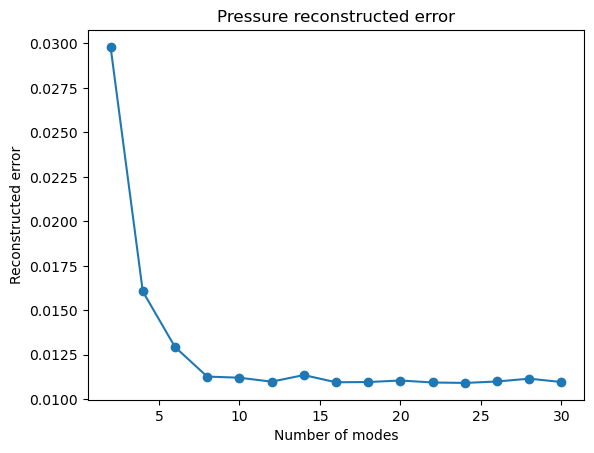

In [10]:
# print the error using 5 modes
p_error_list = np.array(p_error_list)
p_error_mean = np.mean(p_error_list, axis=1)

plt.plot(range(2, 32, 2), p_error_mean, marker='o')
plt.title('Pressure reconstructed error')
plt.xlabel('Number of modes')
plt.ylabel('Reconstructed error')
plt.show()

In [25]:
u_error_list = []
rank_range = [i for i in range(2, 10, 2)] + [i for i in range(10, 32, 4)]

for i in rank_range:

    # Evaluate POD on the velocity data
    u_POD = POD_eval(train_velocity, epsilon=i)

    # Define the GPR model
    ann = ANN([5, 10], nn.Tanh(), [50000,1e-6], frequency_print=5000)

    # Perform PODI on the pressure data
    u_rom = PODI_rom(u_POD, ann, train_design_parameters, train_velocity)

    # Predict the pressure data
    u_predict = u_rom.predict(test_design_parameters)

    # calculate the reconstrcuted error for each test data using mean squared error
    u_error_list.append(np.linalg.norm(test_velocity - u_predict.snapshots_matrix, axis=1) / np.linalg.norm(test_velocity, axis=1))

    # # plot the error
    # plt.bar([i for i in range(len(u_reconstructed_error))], u_reconstructed_error)
    # plt.title('Velocity reconstructed error')
    # plt.xlabel('Test data')
    # plt.ylabel('Reconstructed error')
    # plt.show()

Number of modes: 2
[epoch      1]	1.425535e+03
[epoch   5000]	3.429037e+01
[epoch  10000]	2.136043e+00
[epoch  15000]	2.306891e-02
[epoch  20000]	8.409218e-03
[epoch  25000]	6.439934e-03
[epoch  30000]	5.147063e-03
[epoch  35000]	4.319373e-03
[epoch  40000]	3.953981e-03
[epoch  45000]	3.257750e-03
[epoch  50000]	3.066934e-03
Number of modes: 4
[epoch      1]	7.056100e+02
[epoch   5000]	1.728634e+01
[epoch  10000]	1.896040e+00
[epoch  15000]	3.054504e-02
[epoch  20000]	1.452734e-02
[epoch  25000]	9.691002e-03
[epoch  30000]	8.681396e-03
[epoch  35000]	7.813370e-03
[epoch  40000]	7.351130e-03
[epoch  45000]	7.038372e-03
[epoch  50000]	6.723911e-03
Number of modes: 6
[epoch      1]	4.683016e+02
[epoch   5000]	1.204707e+01
[epoch  10000]	1.191110e+00
[epoch  15000]	3.204796e-01
[epoch  20000]	1.543904e-01
[epoch  25000]	1.863709e-02
[epoch  30000]	1.375461e-02
[epoch  35000]	1.253994e-02
[epoch  40000]	1.196600e-02
[epoch  45000]	1.164445e-02
[epoch  50000]	1.131599e-02
Number of modes: 8


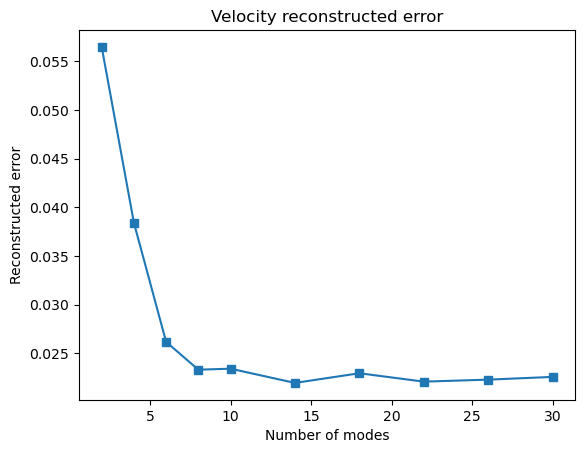

In [26]:
# print the error using different number of modes
u_error = np.array(u_error_list)
u_error_mean = np.mean(u_error, axis=1)

plt.plot(rank_range, u_error_mean, marker='s')
plt.title('Velocity reconstructed error')
plt.xlabel('Number of modes')
plt.ylabel('Reconstructed error')
plt.show()

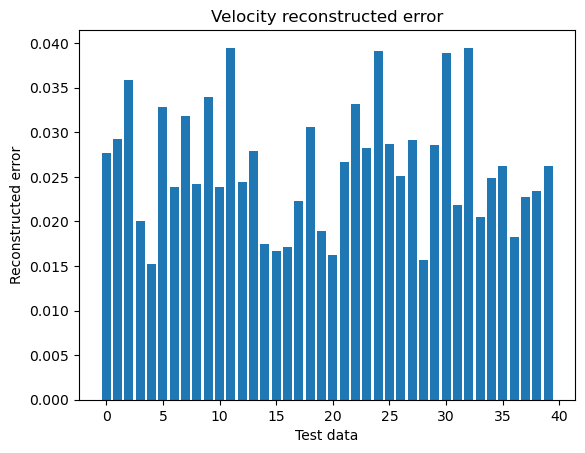

In [27]:
# plot the error of each case when using 22 modes
plt.bar([i for i in range(len(u_error_list[2]))], u_error_list[2])
plt.title('Velocity reconstructed error')
plt.xlabel('Test data')
plt.ylabel('Reconstructed error')
plt.show()

### 5. VTK visualization

In [25]:
# Evaluate POD on the velocity data
u_POD = POD_eval(train_velocity, epsilon=7)

# Define the GPR model
ann = ANN([5, 10], nn.Tanh(), [50000,1e-6], frequency_print=5000)

# Perform PODI on the pressure data
u_rom = PODI_rom(u_POD, ann, train_design_parameters, train_velocity)

# Predict the pressure data
u_predict = u_rom.predict(test_design_parameters)

Number of modes: 7
[epoch      1]	4.052447e+02
[epoch   5000]	9.731461e+00
[epoch  10000]	9.122561e-01
[epoch  15000]	2.141129e-01
[epoch  20000]	2.006309e-01
[epoch  25000]	8.885098e-02
[epoch  30000]	5.400036e-02
[epoch  35000]	1.610199e-02
[epoch  40000]	1.541269e-02
[epoch  45000]	1.500212e-02
[epoch  50000]	1.468611e-02


In [22]:
# Define a funtion to write the data into a VTK file
def vtk_writer(field_data, field_name, data_type,
               refVTM, save_path_name, points_data = None):
    # Add velocity data to each block within the MultiBlock dataset
    
    for block_i in range(refVTM.n_blocks):
        block = refVTM[block_i]
        if block is not None:
            if data_type == 'scalar':
                for data_i in range(len(field_name)):
                    block.cell_data[field_name[data_i]] = field_data[data_i]
            elif data_type == 'vector':
                for data_i in range(len(field_name)):
                    field = field_data[data_i].reshape(3, -1).T
                    block.cell_data[field_name[data_i]] = field 
            if points_data is not None:
                points = points_data.reshape(3, -1).T
                block.points = points

    # Save the modified VTM file
    output_vtm_file_path = f'{save_path_name}.vtm'
    refVTM.save(output_vtm_file_path)

In [15]:
# write the truth data, reconstructed data, and error into a VTK file
# Load the reference mesh VTM file
refVTM = pv.MultiBlock('simulation_data/refCase/VTK/refCase_0.vtm')
field_name = ['truth', 'reconstructed', 'error']
p_error_field = test_pressure - p_predict.snapshots_matrix

# loop all test data and write the data into VTK file
for i in range(len(test_pressure)):
    vtk_writer([test_pressure[i], p_predict.snapshots_matrix[i], p_error_field[i]], 
                field_name, 'scalar', refVTM, f'visualization_data/EZyRB_PODI_ANN/test_case_{i}_pressure', test_points[i])

In [23]:
# Write the velocity data into VTK file
refVTM = pv.MultiBlock('simulation_data/refCase/VTK/refCase_0.vtm')
field_name = ['truth', 'reconstructed', 'error']
u_error_field = test_velocity - u_predict.snapshots_matrix

# loop all test data and write the data into VTK file
for i in range(len(test_velocity)):
    vtk_writer([test_velocity[i], u_predict.snapshots_matrix[i], u_error_field[i]], 
                field_name, 'vector', refVTM, f'visualization_data/EZyRB_PODI_ANN/test_case_{i}_velocity', test_points[i])